## prep

In [2]:
pip install imblearn

     |████████████████████████████████| 206 kB 690 kB/s eta 0:00:01
     |████████████████████████████████| 7.2 MB 348 kB/s eta 0:00:01
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.23.2
    Uninstalling scikit-learn-0.23.2:
      Successfully uninstalled scikit-learn-0.23.2
Note: you may need to restart the kernel to use updated packages.


In [5]:
pip install delayed

     |████████████████████████████████| 72 kB 349 kB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [12]:
pip install imblearn -U

Requirement already up-to-date: imblearn in /Users/liwenyi/opt/anaconda3/lib/python3.8/site-packages (0.0)
Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.svm import SVC

from imblearn.over_sampling import SMOTE
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier

In [4]:
# read orginal file (dfrop max+not P)
ori_data = pd.read_excel("card transactions.xlsx", parse_dates=['Date'])
ori_data = ori_data.loc[(ori_data["Transtype"]=="P")]
ori_data = ori_data.loc[(ori_data["Amount"]!=ori_data["Amount"].max())]

In [5]:
Merchnum = list(ori_data["Merchnum"])

In [6]:
# read variables file 
vars_data = pd.read_csv('after_feature_selection_forward_10.csv', parse_dates=['Date'])

In [7]:
vars_data["Merchnum"]=Merchnum

In [8]:
final = vars_data.copy()

In [9]:
final.head()

,total_Amount_card_description_7,total_Amount_card_description_3,max_Amount_card_state_14,total_Amount_Cardnum_3,total_Amount_card_description_1,total_Amount_Cardnum_0,total_Amount_card_description_0,total_Amount_Cardnum_14,max_Amount_card_state_30,max_Amount_Cardnum_3,Date,Fraud,Amount,Merchnum
0,293.22,293.22,3.67,438.57,293.22,438.57,293.22,438.57,3.67,3.67,2010-01-01,0,3.62,5509006296254
1,31.42,31.42,31.42,31.42,31.42,31.42,31.42,31.42,31.42,31.42,2010-01-01,0,31.42,61003026333
2,178.49,178.49,178.49,178.49,178.49,178.49,178.49,178.49,178.49,178.49,2010-01-01,0,178.49,4503082993600
3,93.20,93.20,3.80,182.84,93.20,182.84,93.20,182.84,3.80,3.80,2010-01-01,0,3.62,5509006296254
4,293.22,293.22,3.67,438.57,293.22,438.57,293.22,438.57,3.67,3.67,2010-01-01,0,3.62,5509006296254


## train model

In [10]:
data = pd.read_csv('after_feature_selection_forward_10.csv', parse_dates=['Date'])

In [11]:
train_test = data[(data.Date >= '2010-01-15') & (data.Date <= '2010-10-31')].drop(columns=['Date'])
OOT = data[data.Date > '2010-10-31'].drop(columns=['Date'])

In [12]:
X = train_test.drop(columns=['Fraud', 'Amount'])
y = train_test['Fraud']
X_OOT = OOT.drop(columns=['Fraud', 'Amount'])
y_OOT = OOT['Fraud']

In [13]:
# Whether you want to resample or not
smote_flag = True

fdr_scores = pd.DataFrame(index=range(10), columns=['train fdr', 'test fdr', 'oot fdr'])
for i in range(10):
    # Use your own model and hyperparameters here
    model = model = MLPClassifier(hidden_layer_sizes=(20),
                      max_iter=400,
                      solver='adam',
                      activation='relu')
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y)
    scaler = StandardScaler()
    X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
    X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)
    X_OOT_scaled = pd.DataFrame(scaler.transform(X_OOT), columns=X_OOT.columns)
    
    #Capped 6
    drop_index = ((X_train_scaled >= 6) | (X_train_scaled <= -6)).sum(axis=1)
    drop_index = drop_index[drop_index >= 1].index.to_list()
    X_train_scaled = X_train_scaled.drop(index=drop_index)
    y_train = pd.DataFrame(y_train).iloc[X_train_scaled.index, :]['Fraud']
    
    if smote_flag:
        y_neg_cnt = (y_train == 0).sum()
        smote = SMOTE(sampling_strategy={0: y_neg_cnt, 1: int(y_neg_cnt/10)})
        X_train_smo, y_train_smo = smote.fit_resample(X_train_scaled, y_train)
        model.fit(X_train_smo, y_train_smo)
    else:
        model.fit(X_train_scaled, y_train)

In [14]:
predict_data_scaled = pd.DataFrame(scaler.transform(final.iloc[:,0:10]), columns=final.iloc[:,0:10].columns)

## assign fraud score

In [15]:
fraud_score = model.predict_proba(predict_data_scaled)[:,1]
final['Fraud Score']=fraud_score.round(5)

In [16]:
final.head()

,total_Amount_card_description_7,total_Amount_card_description_3,max_Amount_card_state_14,total_Amount_Cardnum_3,total_Amount_card_description_1,total_Amount_Cardnum_0,total_Amount_card_description_0,total_Amount_Cardnum_14,max_Amount_card_state_30,max_Amount_Cardnum_3,Date,Fraud,Amount,Merchnum,Fraud Score
0,293.22,293.22,3.67,438.57,293.22,438.57,293.22,438.57,3.67,3.67,2010-01-01,0,3.62,5509006296254,0.00103
1,31.42,31.42,31.42,31.42,31.42,31.42,31.42,31.42,31.42,31.42,2010-01-01,0,31.42,61003026333,0.00075
2,178.49,178.49,178.49,178.49,178.49,178.49,178.49,178.49,178.49,178.49,2010-01-01,0,178.49,4503082993600,0.00214
3,93.20,93.20,3.80,182.84,93.20,182.84,93.20,182.84,3.80,3.80,2010-01-01,0,3.62,5509006296254,0.00074
4,293.22,293.22,3.67,438.57,293.22,438.57,293.22,438.57,3.67,3.67,2010-01-01,0,3.62,5509006296254,0.00103


## plot cardnumber

In [17]:
merchnum = final[["Date","Merchnum","Fraud Score"]].loc[(final["Merchnum"]=='997674930332')]
merchnum["Count"]=list(range(1, len(merchnum)+1))
merchnum.head()

,Date,Merchnum,Fraud Score,Count
6172,2010-01-28,997674930332,0.00070,1
6650,2010-01-31,997674930332,0.00917,2
8115,2010-02-04,997674930332,0.00685,3
15375,2010-03-03,997674930332,0.00089,4
19051,2010-03-16,997674930332,0.00099,5


In [18]:
merchnum_date = merchnum.loc[merchnum["Date"]>="2010-01-16"].loc[merchnum["Date"]<="2010-12-31"].sort_values(by='Date')
merchnum_date

,Date,Merchnum,Fraud Score,Count
6172,2010-01-28,997674930332,0.00070,1
6650,2010-01-31,997674930332,0.00917,2
8115,2010-02-04,997674930332,0.00685,3
15375,2010-03-03,997674930332,0.00089,4
19051,2010-03-16,997674930332,0.00099,5
...,...,...,...,...
54292,2010-07-19,997674930332,0.00067,69
57458,2010-07-28,997674930332,0.00088,70
65821,2010-08-23,997674930332,0.00524,71
67865,2010-08-29,997674930332,0.00622,72


In [56]:
merchnum_date3_5 = merchnum.loc[merchnum["Date"]>="2010-03-01"].loc[merchnum["Date"]<="2010-05-01"].sort_values(by='Date')
merchnum_date3_5.sort_values(by='Date')

,Date,Merchnum,Fraud Score,Count
15375,2010-03-03,997674930332,0.00076,4
19051,2010-03-16,997674930332,0.00092,5
19521,2010-03-17,997674930332,0.00092,6
20976,2010-03-22,997674930332,0.00288,7
23161,2010-03-30,997674930332,0.00101,8
23332,2010-03-30,997674930332,0.00101,9
23466,2010-03-30,997674930332,0.00101,10
23565,2010-03-31,997674930332,0.00063,11
23585,2010-03-31,997674930332,0.00063,12
23639,2010-03-31,997674930332,0.00063,13


Text(0, 0.5, 'Fraud score')

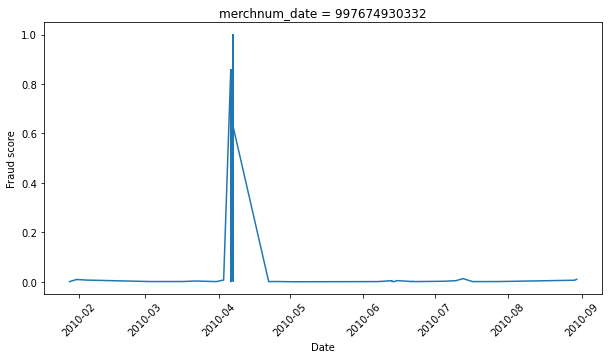

In [19]:
plt.figure(figsize=(10,5))
plt.plot(merchnum_date["Date"], merchnum_date["Fraud Score"])
plt.title("merchnum_date = 997674930332")
plt.xticks(rotation=45)
plt.xlabel("Date")
plt.ylabel("Fraud score")

(array([-10.,   0.,  10.,  20.,  30.,  40.,  50.,  60.,  70.,  80.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

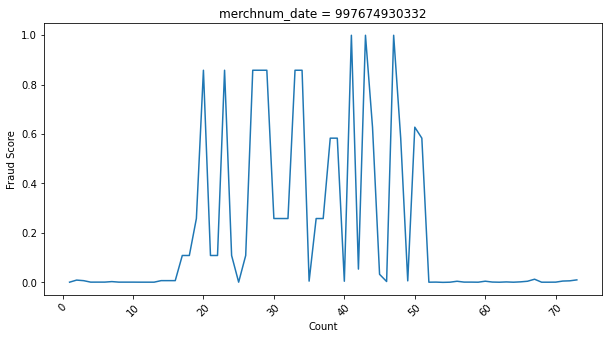

In [21]:
plt.figure(figsize=(10,5))
sns.lineplot(x=merchnum["Count"], y=merchnum["Fraud Score"])
plt.title("merchnum_date = 997674930332")
plt.xticks(rotation=45)

In [19]:
merchnum.sort_values(by=["Fraud Score","Count"], ascending=[False,True])

,Date,Merchnum,Fraud Score,Count
25522,2010-04-07,997674930332,0.99994,41
25549,2010-04-07,997674930332,0.99994,43
25665,2010-04-07,997674930332,0.99994,47
25142,2010-04-06,997674930332,0.87428,20
25217,2010-04-06,997674930332,0.87428,23
...,...,...,...,...
29330,2010-04-22,997674930332,0.00023,52
44645,2010-06-14,997674930332,0.00023,59
54292,2010-07-19,997674930332,0.00023,69
47223,2010-06-22,997674930332,0.00022,64


In [39]:
import numpy as np
np.random.seed(2);x = np.random.standard_normal(50)
## simulate 50 numbers from standard normal distribution 
np.random.seed(2); y = -0.5 * np.random.standard_normal(50)
result = x+2*y

In [40]:
result

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])